## Log-playback (expert) trajectory extraction and usage

This notebook demonstrates how to extract expert actions using different dynamics models and step through scene with those actions. 

Details on the dynamics models are found in [the docs](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env).

In [1]:
import os
from pathlib import Path
import mediapy

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig
from pygpudrive.env.env_torch import GPUDriveTorchEnv
from pygpudrive.visualize.utils import img_from_fig

### Configurations

In [2]:
DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 128
NUM_ENVS = 6

# Configs
render_config = RenderConfig(draw_obj_idx=True)
scene_config = SceneConfig(path=DATA_PATH, num_scenes=NUM_ENVS)
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

### Make environment

In [3]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    max_cont_agents=MAX_NUM_OBJECTS,
    device="cpu",
    render_config=render_config,
    action_type="continuous" # "continuous" or "discrete"
)


--- Ratio unique scenes / number of worlds = 3 / 6 ---



### Get log-playback (expert) actions

- Different dynamics models have different action spaces. For details, [see the docs.](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env)

In [4]:
obs = env.reset()

In [5]:
# Extract full expert trajectory
expert_actions, _, _, _ = env.get_expert_actions()

expert_actions.shape # Shape: (num_envs, num_steps, num_agents, num_actions)

torch.Size([6, 32, 91, 3])

### Step through an episode

In [9]:
# Reset environment
obs = env.reset()

frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

# Step through the scene
for t in range(90):

    env.step_dynamics(expert_actions[:, :, t, :])
    
    # Render the scenes
    if t % 10 == 0:
        figs = env.vis.plot_simulator_state(
            env_indices=list(range(NUM_ENVS)),
            time_steps=[t]*NUM_ENVS,
            figsize=(6, 6),
            zoom_radius=40,
            center_agent_indices=[0]*NUM_ENVS,
        )
        for i in range(NUM_ENVS):
            frames[f"env_{i}"].append(img_from_fig(figs[i])) 

In [10]:
frames.keys()

dict_keys(['env_0', 'env_1', 'env_2', 'env_3', 'env_4', 'env_5'])

## Show videos

env_0,env_1
env_2,env_3
env_4,env_5

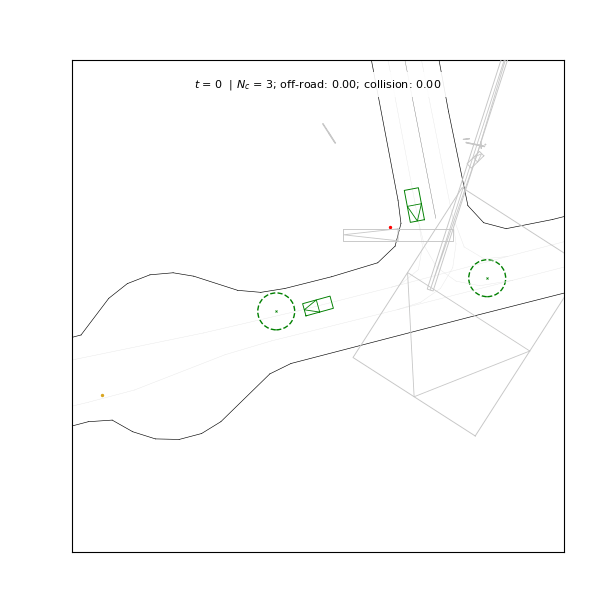
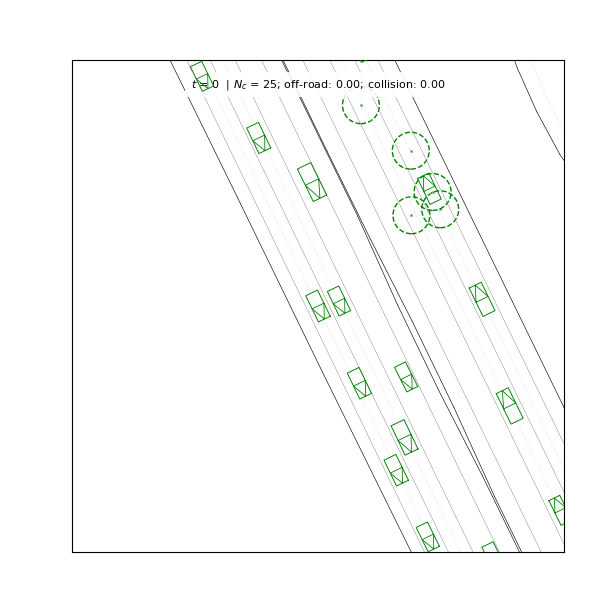
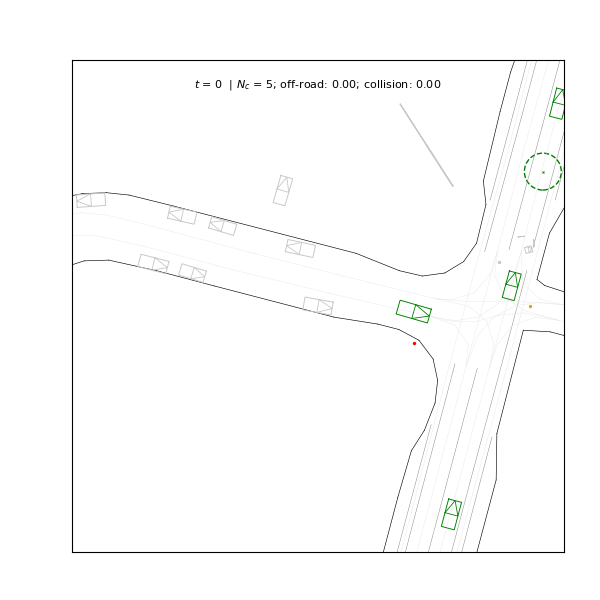
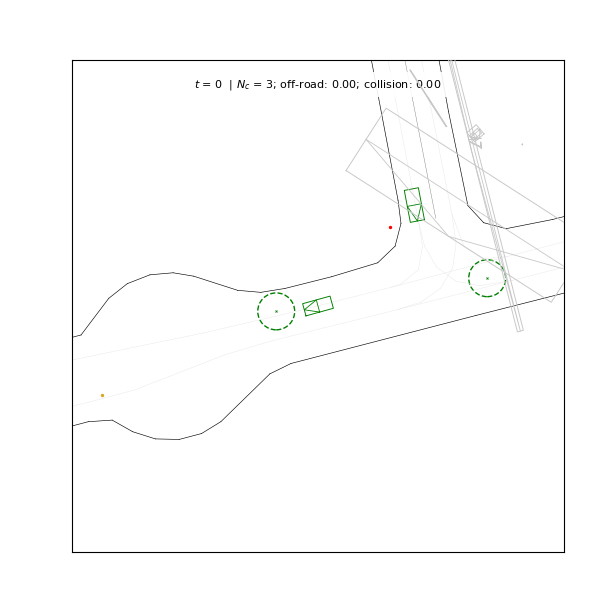
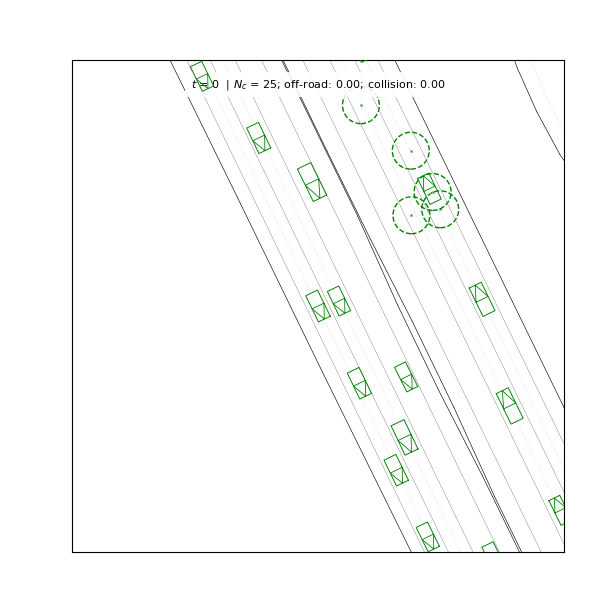
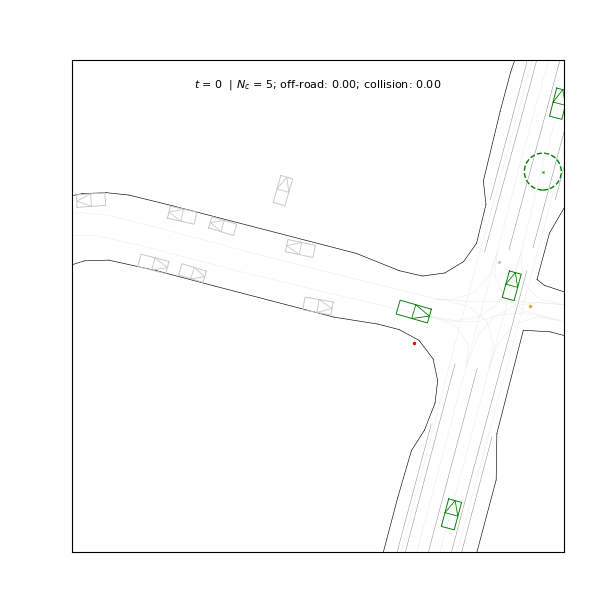

In [11]:
mediapy.show_videos(frames, fps=7, columns=2, codec='gif')